In [8]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [9]:
# Sækjum gögnin úr SkakgreinirGogn
import numpy as np

#leikir_heild = np.loadtxt("leikir_heild_50k.csv", delimiter=",", dtype=int, comments=None)
#leikir_sigurvegari = np.loadtxt("leikir_sigurvegari_50k.csv", delimiter=",", dtype=int, comments=None)
leikir_heild = np.loadtxt("/home/magnus/Documents/Skákgreinir_backup/leikir_heild.csv", delimiter=",", dtype=int, comments=None)
leikir_sigurvegari = np.loadtxt("leikir_sigurvegari.csv", delimiter=",", dtype=int, comments=None)

leikir_heild = leikir_heild[:200000]
leikir_sigurvegari = leikir_sigurvegari[:200000]

# Skoðum aðeins gögnin fyrir hvítann
leikir_heild_hvitur = []
leikir_sigurvegari_hvitur = []
nr_fyrri_leiks = 0
for i in range(leikir_heild.shape[0]):
    nr_nuverandi_leiks = leikir_heild[i,0]
    if nr_fyrri_leiks != nr_nuverandi_leiks:
        leikir_heild_hvitur.append(leikir_heild[i,:])
        leikir_sigurvegari_hvitur.append(leikir_sigurvegari[i])
    nr_fyrri_leiks = nr_nuverandi_leiks

#leikir_heild_hvitur = np.array(leikir_heild_hvitur[:200000])
#leikir_sigurvegari_hvitur = np.array(leikir_sigurvegari_hvitur[:200000])

# Skiptum gögnunum í training og test set
from sklearn.model_selection import train_test_split
#Xtr, Xts, ytr, yts = train_test_split(leikir_heild, leikir_sigurvegari, test_size=0.2, random_state=42)
Xtr, Xts, ytr, yts = train_test_split(leikir_heild_hvitur, leikir_sigurvegari_hvitur, test_size=0.2, random_state=42)
Xtr = torch.tensor(Xtr, device=device, dtype=torch.float)
ytr = torch.tensor(ytr, device=device, dtype=torch.long)
Xts = torch.tensor(Xts, device=device, dtype=torch.float)
yts = torch.tensor(yts, device=device, dtype=torch.long)

In [10]:
# Setjum gögnin á form sem hægt er að nota til að þjálfa netið
from torch.utils.data import DataLoader, TensorDataset

batch_size = 128

train_data = TensorDataset(Xtr, ytr)
test_data = TensorDataset(Xts, yts)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [11]:
# Búum til uppsetninguna á tauganetinu
from torch import nn

n_in, n_out = len(leikir_heild[0,:]), 3
#n_hid1, n_hid2, n_hid3, n_hid4 = 2000, 1500, 1000, 500
#n_hid1, n_hid2, n_hid3 = 1000, 500, 300
#n_hid1, n_hid2, n_hid3 = 100, 100, 100
n_hid1, n_hid2 = 50, 50

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_in, n_hid1, device=device)
        self.hidden2 = nn.Linear(n_hid1, n_hid2, device=device)
        #self.hidden3 = nn.Linear(n_hid2, n_hid3, device=device)
        #self.hidden4 = nn.Linear(n_hid3, n_hid4, device=device)
        self.out = nn.Linear(n_hid2, n_out, device=device)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        #x = self.relu(self.hidden3(x))
        #x = self.relu(self.hidden4(x))
        x = self.softmax(self.out(x))
        return x

model = Net().to(device)
print(model)
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

Net(
  (hidden1): Linear(in_features=772, out_features=50, bias=True)
  (hidden2): Linear(in_features=50, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
The model has 41,353 trainable parameters


In [12]:
# Setjum upp ítrunina
from sklearn.metrics import accuracy_score
num_epochs = 100
train_accuracies, test_accuracies = [], []
train_loss, test_loss = [], []

learning_rate = 0.0001

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss.append(total_loss/len(train_loader))
    # Test
    model.eval()
    with torch.no_grad():
        y_pred = model(Xts)
        test_loss.append(loss_function(y_pred, yts).item())
        test_accuracies.append(accuracy_score(yts.cpu(), y_pred.argmax(1).cpu()))
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')


Epoch 1/100, Training Loss: 0.8834, Test Loss: 0.8590, Test Accuracy: 0.6730
Epoch 2/100, Training Loss: 0.8610, Test Loss: 0.8695, Test Accuracy: 0.6612
Epoch 3/100, Training Loss: 0.8606, Test Loss: 0.8581, Test Accuracy: 0.6737
Epoch 4/100, Training Loss: 0.8603, Test Loss: 0.8581, Test Accuracy: 0.6736
Epoch 5/100, Training Loss: 0.8598, Test Loss: 0.8575, Test Accuracy: 0.6775
Epoch 6/100, Training Loss: 0.8593, Test Loss: 0.8568, Test Accuracy: 0.6780
Epoch 7/100, Training Loss: 0.8586, Test Loss: 0.8594, Test Accuracy: 0.6726
Epoch 8/100, Training Loss: 0.8581, Test Loss: 0.8562, Test Accuracy: 0.6788
Epoch 9/100, Training Loss: 0.8575, Test Loss: 0.8577, Test Accuracy: 0.6750
Epoch 10/100, Training Loss: 0.8570, Test Loss: 0.8556, Test Accuracy: 0.6783
Epoch 11/100, Training Loss: 0.8568, Test Loss: 0.8563, Test Accuracy: 0.6789
Epoch 12/100, Training Loss: 0.8560, Test Loss: 0.8566, Test Accuracy: 0.6762
Epoch 13/100, Training Loss: 0.8555, Test Loss: 0.8552, Test Accuracy: 0.

In [13]:
# from sklearn.metrics import accuracy_score
# num_epochs = 30
# train_accuracies, test_accuracies = [], []
# train_loss, test_loss = [], []

# learning_rate = 0.001
# loss_function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# for epoch in range(num_epochs):
#     # Train set
#     for X, y in train_loader:        
#         # Forward
#         y_pred = model(X)
#         y_pred_labels = torch.argmax(y_pred, axis=1)
#         loss = loss_function(y_pred_labels, y)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#     train_accuracies.append(accuracy_score(ytr.cpu(), torch.argmax(model(Xtr), axis=1).cpu()))
#     train_loss.append(loss.item())
    
#     # Test set
#     X, y = next(iter(test_loader))
#     #y = y.type(torch.LongTensor).to(device)
#     y_pred_labels = torch.argmax(model(X), axis=1)
#     test_accuracies.append(accuracy_score(yts.cpu(), torch.argmax(model(Xts), axis=1).cpu()))
#     test_loss.append(loss_function(model(X), y).item())

Text(0.5, 0, 'Ítranir')

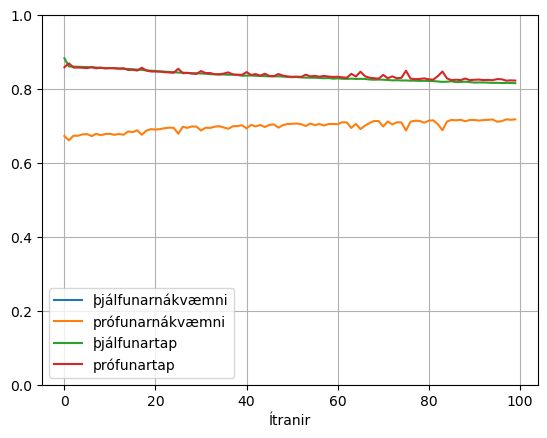

In [14]:
# Sýnum niðurstöður
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='þjálfunarnákvæmni')
plt.plot(test_accuracies, label='prófunarnákvæmni')
plt.plot(train_loss, label='þjálfunartap')
plt.plot(test_loss, label='prófunartap')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Ítranir')